<a href="https://colab.research.google.com/github/ck1972/Python-Geospatial_Model1/blob/main/2b_Modeling_AGBD_GEDI_S2_SpectralIndices_RF_Model_GEE_MafungautsiForestReserve_Scale_Sensitivity_Analysis_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Aboveground Biomass Density Models with GEDI, Sentinel-2, and Machine Learning: Addressing Overfitting via a Data-centric Approach

## Aim
In the previous script, we observed that the random forest model was overfitting. In this tutorial, we will attempt to mitigate the overfitting problem by improving the quality and quantity of the training dataset. We will use  'quality_mask', 'error_mask' and 'slope_mask' functions to mask unreliable Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A) aboveground biomass density measurements. This script aims to improve the accuracy of GEDI L4A AGBD estimates by excluding measurements with high uncertainty and those taken on steep slopes, which can affect the reliability of the data. We will also analyze scale sensitivity to determine which scale provides the best model results.


## Requirements
To run this script, the user must have an Earth Engine account. In addition, the user must authenticate the Earth Engine Python API. See the instructions [here](https://developers.google.com/earth-engine/guides/auth).

Following are the steps to model AGBD.

# Initialize and Authenticate Earth Engine
To get started with Google Earth Engine (GEE), you need to initialize and authenticate the Earth Engine API. Follow these steps.


First, import the Earth Engine API by importing the ee module into your Python environment. This module allows you to interact with the Earth Engine platform.


In [ ]:
# Import the API
import ee

Next, initialize the Earth Engine API. You must initialize the API to use Earth Engine functionalities. This involves authenticating your session and initializing the library. When you run the ee.Initialize() command for the first time, you might be prompted to authenticate your session. This will open a web browser window where you need to log in with your Google account and grant Earth Engine access.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-xxxx-test')

## Import Libraries
Next, import the essential libraries needed to process and analyze the datasets.

In [ ]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geemap import chart

# Import Datasets
## Import the project boundary
First, import the forest reserve project boundary from the Google Earth Engine catalog's World Database on Protected Areas ('WCMC/WDPA/current/polygons'). The World Database on Protected Areas (WDPA) is the most up-to-date and comprehensive source of information on protected areas, updated monthly with submissions from governments, non-governmental organizations, landowners, and communities. It is managed by the United Nations Environment Programme's World Conservation Monitoring Centre (UNEP-WCMC) with support from the IUCN and its World Commission on Protected Areas (WCPA). You can select your project forest reserve or protected area from the WDPA database.

Source: https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons



In [ ]:
## Use the code below to search for the forest reserve or protected area in your country of interest.
# Load the WDPA data
protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# Filter for protected areas in Zimbabwe
zimbabwe_protected_areas = protected_areas.filter(ee.Filter.eq('PARENT_ISO', 'ZWE'))

# Select the 'NAME' property of the features
names = zimbabwe_protected_areas.aggregate_array('NAME')

# Print the names of the protected areas
print(names.getInfo())

['Mana Pools National Park, Sapi and Chewore Safari Areas', 'Ewanrrig', 'National Botanic', 'Vumba', 'Pioneer, Tolo River, South Camp', 'Sebakwe', 'Vumba', 'Bunga Forest', 'Rusitu Forest', 'Haroni Forest', 'Tingwa Raphia Palm', 'Mazowe', 'Chisekera Hot Springs', 'Mawari Raphia Palm', 'Bubye Valley Conservancy', 'Gwayi Conservancy', 'Midlands Black Rhino Conservancy', 'Bubiana', 'Chiredzi River Conservancy', 'Malilangwe Conservancy', 'Save Conservancy', 'Gonarezhou', 'Chizarira', 'Matusadona', 'Matopos', 'Nyanga', 'Kazuma Pan', 'Hwange', 'Victoria Falls', 'Zambezi', 'Mana Pools', 'Chimanimani', 'Osborne', 'Lake Cunningham', 'Kyle', 'Ngezi', 'Sebakwe', 'Lake Kariba', 'Darwendale', 'Lake Chivero', 'Bangala', 'Umzingwane', 'Manjirenji', 'Chinhoyi Caves', 'Mupfure', 'Kavira', 'Chete', 'Chirisa', 'Charara', 'Chewore', 'Sapi', 'Hurungwe', 'Dande', 'Matetsi', 'Tuli', 'Sibilobilo SA', 'Umfurudzi', 'Chegutu', 'Doma', 'Chipinge', 'Deka', 'Malipati', 'Mushandike', 'Tshabalala', 'Manjinji Pan', 'Ny

Select the project area.

In [ ]:
# Define the boundary for Mafungabusi forest reserve
boundary = ee.FeatureCollection('WCMC/WDPA/current/polygons') \
    .filter(ee.Filter.inList('NAME', ['Mafungabusi']))

## Create Sentinel-2 composite and calculate spectral indices
We will use Sentinel-2, the Normalized Difference Vegetation Index (NDVI), Soil Adjusted Vegetation Index (SAVI) and the Red Edge Spectral Index (RESI).


In [ ]:
# Load Sentinel-2 spectral reflectance data.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Create a function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

# Create a single composite image for a given period.
start_date = '2022-01-01'
end_date = '2022-04-30'

# Filter clouds from Sentinel-2 for the given period.
composite = s2.filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])  # Select bands for display

# Compute the median composite and clip to the boundary.
S2_composite = composite.median().clip(boundary)

# Initialize our map.
map1 = geemap.Map()
map1.centerObject(boundary, 12)

# Add the composite image to the map with specified display settings.
map1.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

# Display the map with layer control.
map1.addLayerControl()
map1

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Compute spectral indices
Next, calculate NDVI, SAVI, and RESI.

In [ ]:
# Calculate NDVI
ndvi = S2_composite.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Calculate SAVI.
L = 0.5  # Soil adjustment factor, typically between 0 and 1
savi = S2_composite.expression(
    '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
        'NIR': S2_composite.select('B8'),
        'Red': S2_composite.select('B4'),
        'L': L
    }).rename('SAVI')

# Calculate RESI
resi = S2_composite.expression(
    '((RE3 + RE2 - RE1) / (RE3 + RE2 + RE1))', {
        'RE1': S2_composite.select('B5'),
        'RE2': S2_composite.select('B6'),
        'RE3': S2_composite.select('B7')
    }).rename('RESI')

# Initialize our map.
map2 = geemap.Map()
map2.centerObject(boundary, 12)

# Add the NDVI and RESI layers to the map.
map2.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
map2.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SAVI')
map2.addLayer(resi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RESI')

# Display the map with layer control.
map2.addLayerControl()
map2

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Load other datasets
Import other datasets such as the Shuttle Radar Topography Mission (SRTM) digital elevation model (DEM). Add the SRTM DEM data and calculate slope.

In [ ]:
# Load SRTM DEM
SRTM = ee.Image("USGS/SRTMGL1_003")

# Clip Elevation to the boundary
elevation = SRTM.clip(boundary)

# Derive slope from the SRTM
slope = ee.Terrain.slope(SRTM).clip(boundary)

# Compute the minimum and maximum elevation values within the boundary.
min_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

max_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

print(f"Min Elevation: {min_elevation}, Max Elevation: {max_elevation}")

# Initialize our map.
map4 = geemap.Map()
map4.centerObject(boundary, 12)

# Define attractive color gradients for elevation and slope
elevationPalette = ['006633', '99cc00', 'ffff00', 'ff9900', 'ff6600', 'ff3333', 'ff0000', 'cc0000', '990000', '660000', '330000', '000000']
slopePalette = ['440154', '482878', '3E4A89', '31688E', '26838F', '1F9D8A', '6CCE59', 'B6DE2B', 'FDE724']

# Add elevation layer to the map with new palette
vis_params_elevation = {'min': min_elevation, 'max': max_elevation, 'palette': elevationPalette}
map4.addLayer(elevation, vis_params_elevation, 'Elevation')

# Add slope layer to the map with new palette
vis_params_slope = {'min': 0, 'max': 60, 'palette': slopePalette}
map4.addLayer(slope, vis_params_slope, 'Slope')

# Display the map with layer control.
map4.addLayerControl()
map4

Min Elevation: 1112, Max Elevation: 1341


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Merge all predictor variables
Combine Sentinel-2 bands, spectral indices (NDVI, SAVI, RESI), elevation (SRTM DEM), and slope.

In [ ]:
# Merge the predictor variables
mergedCollection = (
    S2_composite
    .addBands(ndvi)
    .addBands(savi)
    .addBands(resi)
    .addBands(elevation)
    .addBands(slope)
)

# Clip the output image to the farm boundary
clippedmergedCollection = mergedCollection.clipToCollection(boundary)

## Extract AGBD from GEDI Level 4A
Derive aboveground biomass density (AGBD) from the GEDI Level 4A (L4A) dataset. This dataset contains AGBD predictions in Mg/ha. More information about this dataset is available at: https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI04_A_002. This script will process the GEDI Level 4A dataset to filter and enhance the quality of aboveground biomass density (AGBD) measurements.

In [ ]:
# Select a time-period
start_date = ee.Date.fromYMD(2022, 1, 1)
end_date = ee.Date.fromYMD(2022, 5, 30)

# Load the GEDI Level 4A dataset
gedi = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY')

# Function to select highest quality GEDI data
def quality_mask(image):
    return image.updateMask(image.select('l4_quality_flag').eq(1)) \
                .updateMask(image.select('degrade_flag').eq(0))

# Function to mask unreliable GEDI measurements with a relative standard error > 50%
def error_mask(image):
    relative_se = image.select('agbd_se').divide(image.select('agbd'))
    return image.updateMask(relative_se.lte(0.5))

# Function to mask GEDI measurements on slopes > 30%
def slope_mask(image):
    # Load the SRTM digital elevation model
    srtm = ee.Image('USGS/SRTMGL1_003')

    # Calculate slope
    slope = ee.Terrain.slope(srtm)

    return image.updateMask(slope.lt(30))

# Apply the filters
gedi_filtered = gedi.filter(ee.Filter.date(start_date, end_date)) \
                    .filter(ee.Filter.bounds(boundary))

gedi_projection = ee.Image(gedi_filtered.first()).select('agbd').projection()

gedi_processed = gedi_filtered.map(quality_mask).map(error_mask).map(slope_mask)

# Create a mosaic of the filtered images
gedi_mosaic = gedi_processed.mosaic().select('agbd').setDefaultProjection(gedi_projection).clip(boundary)

# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue',
}

# Sample the training points (ta) from the dataset
points = gedi_mosaic.sample(
    region=boundary,
    scale=10,
    geometries=True
)

# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = points.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(points.size().getInfo())
print(points.first().getInfo())

Mean AGBD: 55.953851938464354
Median AGBD: 54.02808380126953
Standard Deviation AGBD: 24.650899229867175
Minimum AGBD: 6.068545818328857
Maximum AGBD: 228.418274
33408
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.863933631158606, -18.48707234741795]}, 'id': '0', 'properties': {'agbd': 103.956032}}


## Display GEDI Level 4A AGBD
Next, display GEDI AGBD sample points.

In [ ]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map5 = geemap.Map()
map5.centerObject(boundary, 12)
map5.addLayer(gedi_mosaic, gediVis, 'GEDI L4A Mean AGBD points')
map5.addLayer(points, {'color': '808080'}, 'Mean AGBD training points')

# Display the map
display(map5)

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Perform exploratory data analysis (EDA)
### Pre-data cleaning EDA
Next, create density and box plots for the GEDI L4A datasets using the seaborn library for density plots and matplotlib for box plots.

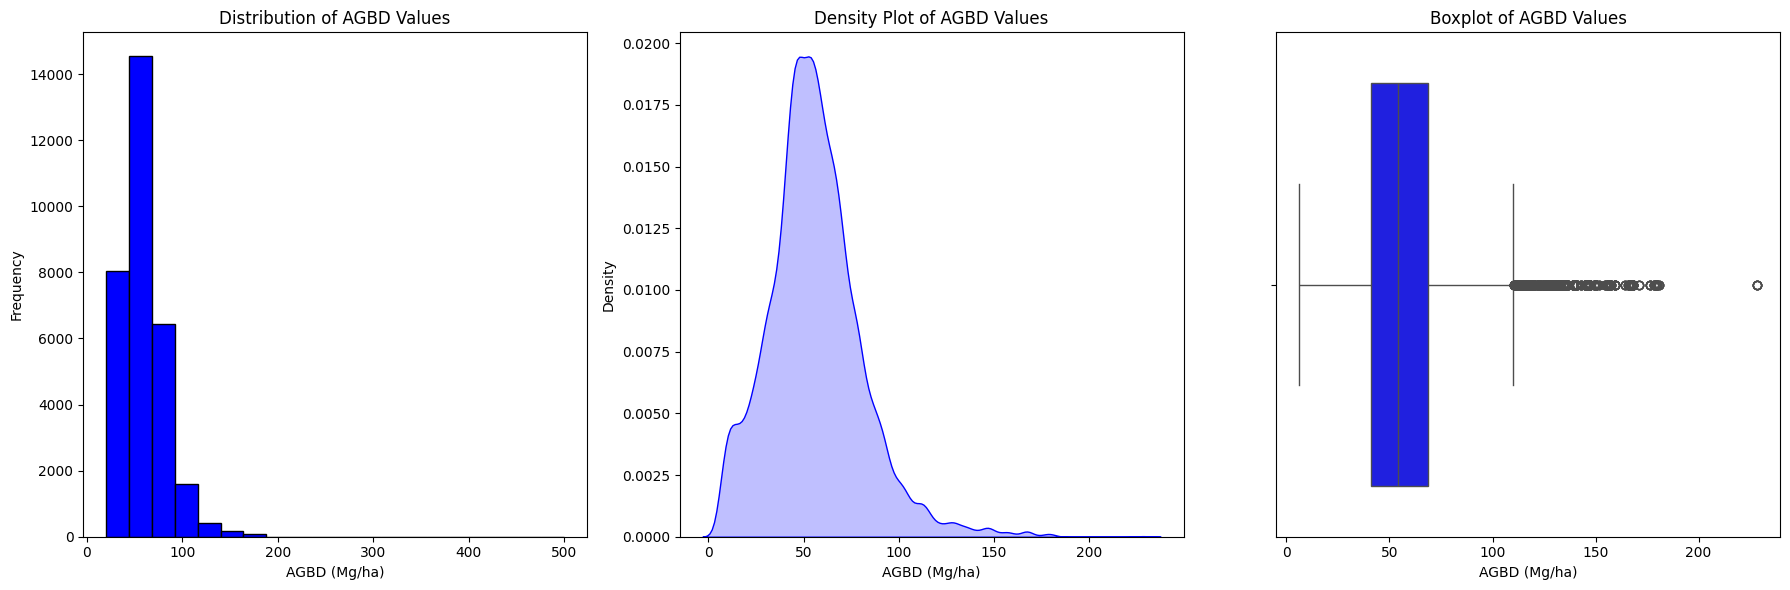

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot a histogram of AGDB values
axes[0].hist(agbd_values, bins=20, range=[20, 500], color='blue', edgecolor='black')
axes[0].set_xlabel('AGBD (Mg/ha)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of AGBD Values')

# Plot a density plot of AGDB values using seaborn
sns.kdeplot(agbd_values, shade=True, color='blue', ax=axes[1])
axes[1].set_xlabel('AGBD (Mg/ha)')
axes[1].set_ylabel('Density')
axes[1].set_title('Density Plot of AGBD Values')

# Plot a boxplot of AGDB values using seaborn
sns.boxplot(x=agbd_values, color='blue', ax=axes[2])
axes[2].set_xlabel('AGBD (Mg/ha)')
axes[2].set_title('Boxplot of AGBD Values')

# Adjust layout for better display
plt.tight_layout()
plt.show()

## Data cleaning

The EDA analysis revealed that GEDI L4A AGBD values ranged broadly from 0.87 Mg/ha to 228.42 Mg/ha. However, field data from a research paper with similar vegetation conditions indicated a mean AGBD of 56 Mg/ha, with AGBD values ranging from 11 to 95 Mg/ha. Therefore, we will filter the points to get AGBD within a range of 0 to 90 Mg/ha.

In [ ]:
# Filter the training points by range (0 Mg/ha to 100 Mg/ha)
filteredPoints = points.filter(
    ee.Filter.And(
        ee.Filter.gte('agbd', 0),
        ee.Filter.lte('agbd', 90)
    )
)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(filteredPoints.size().getInfo())
print(filteredPoints.first().getInfo())

# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map6 = geemap.Map()
map6.centerObject(boundary, 12)
map6.addLayer(filteredPoints, {'color': '808080'}, 'Mean fitered AGBD training points')
# Display the map
display(map6)

30785
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.879554949225398, -18.486917895039422]}, 'id': '6', 'properties': {'agbd': 61.624183654785156}}


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

Next, create density and box plots for the GEDI L4A datasets after data cleaning.

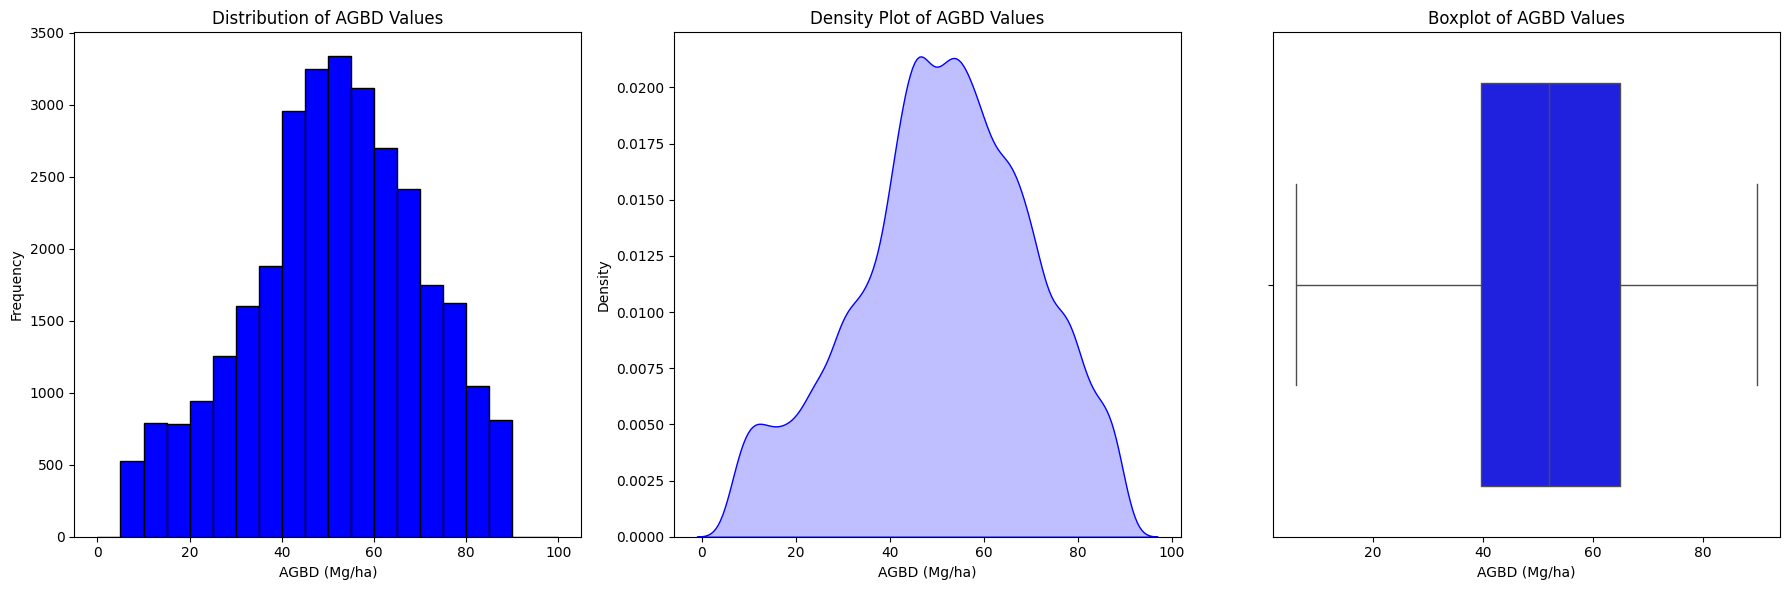

In [ ]:
# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values_filtered = filteredPoints.aggregate_array('agbd').getInfo()

# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot a histogram of AGDB values
axes[0].hist(agbd_values_filtered, bins=20, range=[0, 100], color='blue', edgecolor='black')
axes[0].set_xlabel('AGBD (Mg/ha)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of AGBD Values')

# Plot a density plot of AGDB values using seaborn
sns.kdeplot(agbd_values_filtered, shade=True, color='blue', ax=axes[1])
axes[1].set_xlabel('AGBD (Mg/ha)')
axes[1].set_ylabel('Density')
axes[1].set_title('Density Plot of AGBD Values')

# Plot a boxplot of AGDB values using seaborn
sns.boxplot(x=agbd_values_filtered, color='blue', ax=axes[2])
axes[2].set_xlabel('AGBD (Mg/ha)')
axes[2].set_title('Boxplot of AGBD Values')

# Adjust layout for better display
plt.tight_layout()
plt.show()


# Modeling AGBD using Random Forests
## Prepare training and testing data
Next, split training datasets into training and testing sets. Then check the size of the training and testing data.


In [ ]:
# Split the data into 70% training and 30% testing
ta_points_random = filteredPoints.randomColumn('random')
training = ta_points_random.filter(ee.Filter.lte('random', 0.7))
testing = ta_points_random.filter(ee.Filter.gt('random', 0.7))

# Check training data set
print(training.size().getInfo())
print(training.first().getInfo())

# Check the size of the testing data
print(testing.size().getInfo())
print(testing.first().getInfo())

21543
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.879554949225398, -18.486917895039422]}, 'id': '6', 'properties': {'agbd': 61.624183654785156, 'random': 0.29031444272248386}}
9242
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.887129855174432, -18.486932878169007]}, 'id': '11', 'properties': {'agbd': 57.52329635620117, 'random': 0.7412221183650421}}


## Perform sensitivity analysis and run the random forest regression model
Next, we will conduct a sensitivity analysis to determine how changes in scale affect the random forest model outputs. This will help us to identify the most appropriate scale that balances detail and generalization. In Earth Engine, the scale factor, especially when using functions like image.sampleRegions(), is crucial for defining the spatial resolution at which data is processed and sampled.

In [ ]:
# Define the range of scales to test
scales = [10, 20, 30, 50, 100, 200]  # in meters

# Define the predictor ('variables') and response ('label') features
predictors = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI', 'SAVI','RESI', 'elevation', 'slope']
response = 'agbd'

# Function analyze scale
def analyze_scale(scale):
    sampled = clippedmergedCollection.sampleRegions(**{
        'collection': training,
        'scale': scale,
        'properties': [response],
        'geometries': True
    })

    model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 50
    }).setOutputMode('REGRESSION').train(**{
        'features': sampled,
        'classProperty': response,
        'inputProperties': predictors
    })

    # Predict validation
    prediction = clippedmergedCollection.classify(model).rename('predictedValue')

    validation = prediction.sampleRegions(**{
        'collection': testing,
        'properties': [response],
        'scale': scale
    })

    # Get observed and predicted values
    observed = validation.aggregate_array(response).getInfo()
    predicted = validation.aggregate_array('predictedValue').getInfo()

    # Calculate RMSE
    rmse = [(obs - pred) ** 2 for obs, pred in zip(observed, predicted)]
    mse = sum(rmse) / len(rmse)
    rmse_result = mse ** 0.5

    # Calculate R²
    mean_observed = sum(observed) / len(observed)
    ss_tot = sum((obs - mean_observed) ** 2 for obs in observed)
    ss_res = sum(rmse)
    r_squared = 1 - (ss_res / ss_tot)

    return {
        'RMSE': rmse_result,
        'R2': r_squared
    }

# Map the analyze_scale function over the scales array and handle results
results = [analyze_scale(scale) for scale in scales]

# Function to print results
def handle_results(computed_results):
    for index, result in enumerate(computed_results):
        print(f'Scale: {scales[index]} - RMSE: {result["RMSE"]}, R²: {result["R2"]}')

# Handle the results
handle_results(results)

Scale: 10 - RMSE: 13.808658003910963, R²: 0.4610020760720003
Scale: 20 - RMSE: 10.946823081475477, R²: 0.6612647887592074
Scale: 30 - RMSE: 9.240366898395886, R²: 0.7586415120524851
Scale: 50 - RMSE: 8.406822561737822, R²: 0.8002218867387657
Scale: 100 - RMSE: 9.663668017777685, R²: 0.7360217478800495
Scale: 200 - RMSE: 11.661777746612584, R²: 0.6154009345092291


Plot the scale sensitivity results.

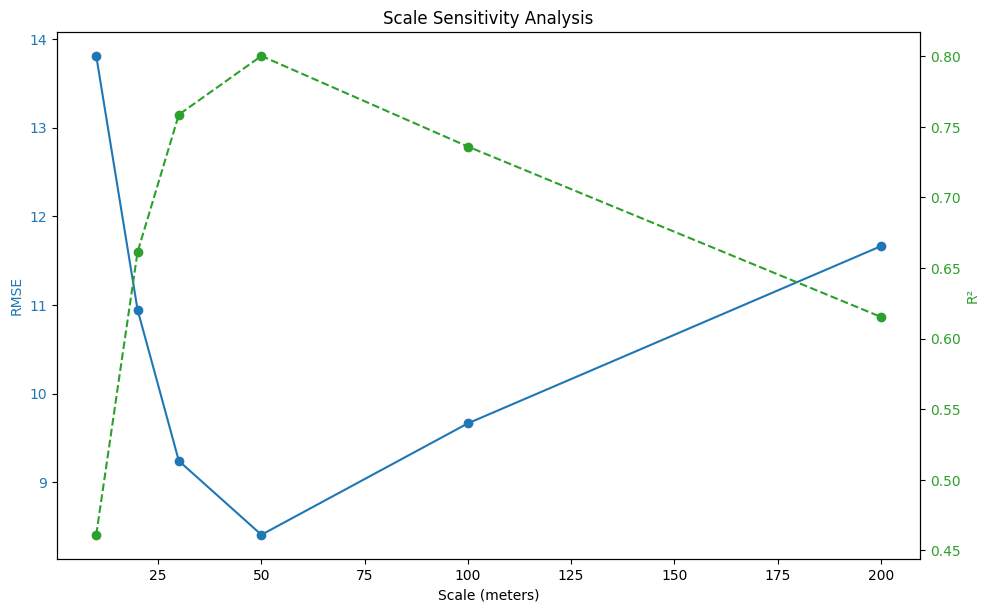

In [ ]:
# Map the analyze_scale function over the scales array and handle results
# results = [analyze_scale(scale) for scale in scales]

# Extract RMSE and R² values for plotting
rmse_values = [result['RMSE'] for result in results]
r2_values = [result['R2'] for result in results]

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Scale (meters)')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(scales, rmse_values, color=color, marker='o', label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('R²', color=color)  # we already handled the x-label with ax1
ax2.plot(scales, r2_values, color=color, marker='o', linestyle='--', label='R²')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Scale Sensitivity Analysis')
plt.show()

## Display AGBD maps
Finally, we will display all the AGBD maps.

In [ ]:
# Initialize the map
map6 = geemap.Map()
map6.centerObject(boundary, 12)

# For each scale, predict and display results
for scale in scales:
    model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 50
    }).setOutputMode('REGRESSION').train(**{
        'features': clippedmergedCollection.sampleRegions(**{
            'collection': testing,
            'scale': scale,
            'properties': [response],
            'geometries': True
        }),
        'classProperty': response,
        'inputProperties': predictors
    })

    prediction = clippedmergedCollection.classify(model)

    viz = {
        'min': 0,
        'max': 120,  # Adjust based on expected range of your data
        'palette': ['#FFFF00', '#ADFF2F', '#32CD32', '#2E8B57', '#006400']
    }
    map6.addLayer(prediction, viz, 'Prediction at scale {}'.format(scale))

# Add color bar to the map
map6.add_colorbar(viz, label="AGBD (Mg/ha)", layer_name="AGBD map")

# Display the map
map6.addLayerControl()
map6

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…